In [126]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ROOT
import ctypes
import math
try:
#     plt.style.use('belle2')
    plt.style.use('belle2_serif')
#     plt.style.use('belle2_modern')
except OSError:
    print("Please install belle2 matplotlib style")   
px = 1/plt.rcParams['figure.dpi']

from main.data_tools.extract_ntuples import get_pd, get_np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
sig_file = ROOT.TFile.Open("/media/jykim/T7/storage/01_recon/phi/D0_massveto_v2_half_1_sig_ext_signalMC_recon_mdst_phi.root")
signal_tree = sig_file.Get("phi")
bkg_file = ROOT.TFile.Open("/media/jykim/T7/storage/01_recon/phi/specific_bkg/signal_extraction_D2phipi0_mdst_1M.root")
background_tree = bkg_file.Get("phi")

In [128]:
mgg = ROOT.TH1F("mgg","di photon mass",50,1.67,2.06)
mgg_background = ROOT.TH1F("mgg_background","background di photon mass",50,1.67,2.06)

In [129]:
def extract_histo(tree, histogram):
    for event in tree:
        histogram.Fill(event.D0_M)
    return histogram

In [130]:
def apply_cuts(tree, histogram):
    for event in tree:
        if event.D0_M > 1.67 and event.D0_M < 2.06:
            histogram.Fill(event.D0_M)
    return histogram

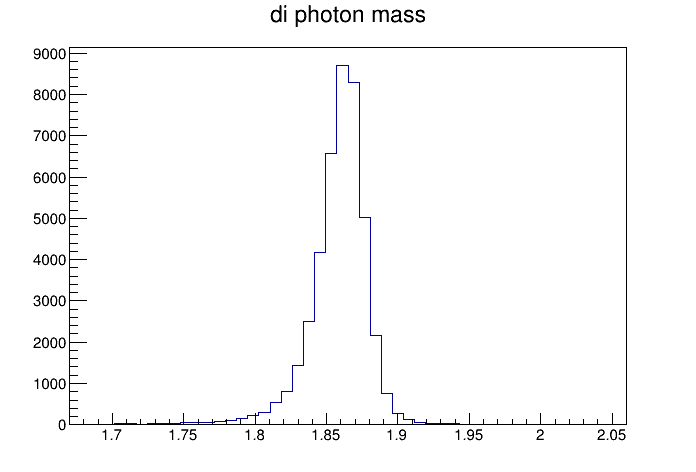

In [131]:

mgg = apply_cuts(signal_tree, mgg)
c1 = ROOT.TCanvas()
mgg.Draw()
c1.Draw()

 FCN=11725.4 FROM MIGRAD    STATUS=CONVERGED      79 CALLS          80 TOTAL
                     EDM=6.89961e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.28792e+01   3.14107e-01   6.23075e-04  -3.30418e-03
   2  Slope       -9.90210e+00   1.77743e-01   3.52575e-04  -5.21152e-03


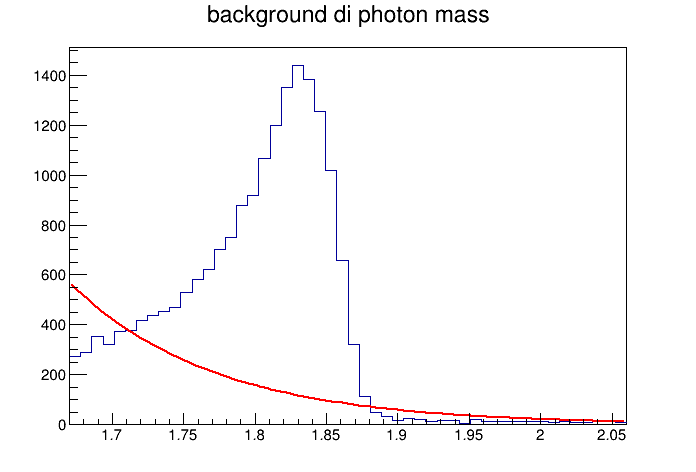

In [132]:

mgg_background = apply_cuts(background_tree, mgg_background)
c1 = ROOT.TCanvas()
mgg_background.Draw()
fitResultPtr = mgg_background.Fit("expo","S")


c1.Draw()

Info in <TCanvas::Print>: png file test.png has been created


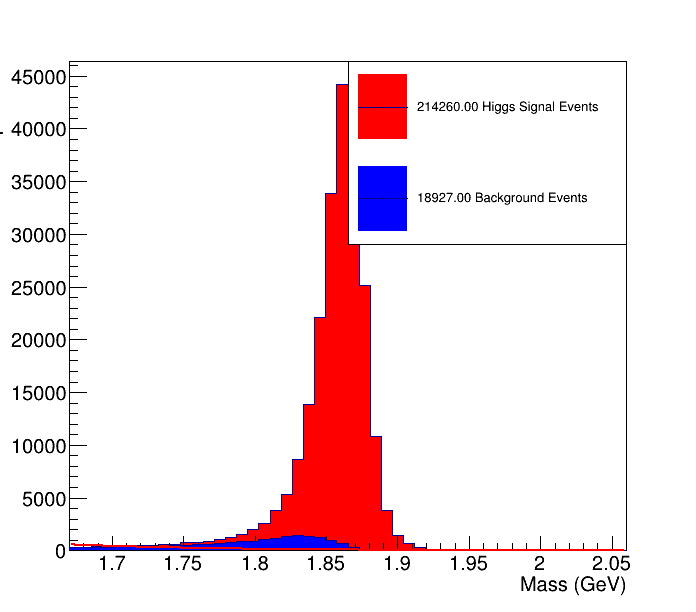

In [133]:
c1 = ROOT.TCanvas("Canvas", "Canvas", 700, 640)


ROOT.gStyle.SetOptStat(0)
mgg.SetFillColor(2)
mgg.SetStats(0)
mgg.Scale(5)
mgg_background.SetFillColor(4)
mgg_background.SetStats(0)
leg = ROOT.TLegend(0.5,0.6,0.9,0.9)
leg.AddEntry(mgg,"{:.2f} Higgs Signal Events".format(mgg.Integral()))
leg.AddEntry(mgg_background,"{:.2f} Background Events".format(mgg_background.Integral()))
stack = ROOT.THStack()
stack.Add(mgg_background)
stack.Add(mgg)
stack.Draw("HIST")
mgg_background.Draw("same")
leg.Draw()
stack.GetXaxis().SetTitle("Mass (GeV)")
stack.GetYaxis().SetTitle("Events per GeV")
c1.Draw()
c1.SaveAs("test.png")

In [134]:
x = ROOT.RooRealVar("x","x",1.67,2.06)
l = ROOT.RooArgList(x)

In [135]:
signalhist = ROOT.RooDataHist("sighist", "sighist", l, mgg)
# signalhist = ROOT.RooDataHist("sighist", "sighist", l, mgg,0.5)

sigpdf = ROOT.RooHistPdf("sigpdf","sigpdf",ROOT.RooArgSet(x),signalhist,0)
bkghist = ROOT.RooDataHist("bkghist", "bkghist", l, mgg_background)
bkgpdf = ROOT.RooHistPdf("bkgpdf","bkgpdf",ROOT.RooArgSet(x),bkghist,0)


In [136]:
mean = ROOT.RooRealVar("mean","Mean of Gaussian",1.86,1.7,1.9)
sigma = ROOT.RooRealVar("sigma","Width of Gaussian",0.01,0.001,0.1)
hgammagamma = ROOT.RooGaussian("Hgammagamma","Gaussian with mean",x,mean,sigma)

In [137]:
hgammagamma.fitTo(signalhist,ROOT.RooFit.Range(1.67,2.06),ROOT.RooFit.PrintLevel(-1))


<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit' created with bounds [1.67,2.06]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_Hgammagamma_sighist) constructing test statistic for sub-range named fit
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'NormalizationRangeForfit' created with bounds [1.67,2.06]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit_nll_Hgammagamma_sighist' created with bounds [1.67,2.06]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_Hgammagamma_sighist) fixing interpretation of coefficients of any RooAddPdf to full domain of observables 
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


[#1] INFO:Plotting -- RooAbsPdf::plotOn(Hgammagamma) p.d.f was fitted in a subrange and no explicit Range() and NormRange() was specified. Plotting / normalising in fit range. To override, do one of the following
	- Clear the automatic fit range attribute: <pdf>.setStringAttribute("fitrange", nullptr);
	- Explicitly specify the plotting range: Range("<rangeName>").
	- Explicitly specify where to compute the normalisation: NormRange("<rangeName>").
	The default (full) range can be denoted with Range("") / NormRange("").
[#1] INFO:Plotting -- RooAbsPdf::plotOn(Hgammagamma) only plotting range 'fit_nll_Hgammagamma_sighist'
[#1] INFO:Plotting -- RooAbsPdf::plotOn(Hgammagamma) p.d.f. curve is normalized using explicit choice of ranges 'fit_nll_Hgammagamma_sighist'


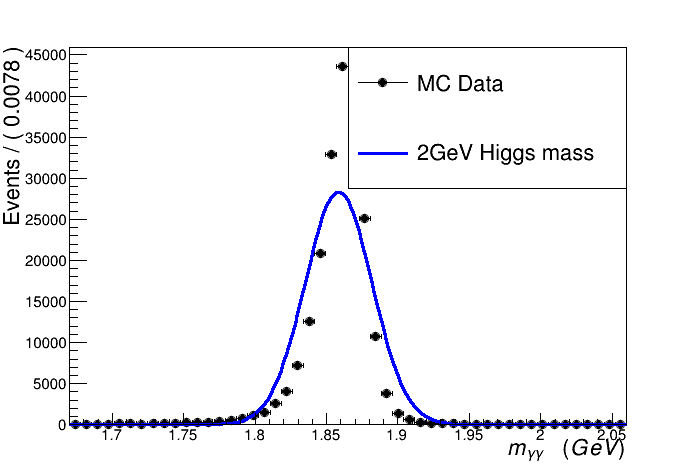

In [138]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Signal Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleOffset(.6)
plot.SetXTitle(r"$m_{\gamma\gamma}$ (GeV)")
signalhist.plotOn(plot,ROOT.RooFit.Name("data"))
hgammagamma.plotOn(plot,ROOT.RooFit.Name("hgg"))

l = ROOT.TLegend( 0.5, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
hobj = plot.findObject("hgg")

l.AddEntry( dataobj , "MC Data", "pl" )
l.AddEntry( hobj , "{0:0.0f}GeV Higgs mass ".format(mean.getVal()), "l"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()

In [139]:
hgammagamma

In [140]:
lamb = ROOT.RooRealVar("lambda","Decay rate of exponential",-1,-2,0)
nonhiggs = ROOT.RooExponential("ztautau","Exponential",x,lamb)

In [141]:
nonhiggs.fitTo(bkghist,ROOT.RooFit.Range(100,160),ROOT.RooFit.PrintLevel(-1))


<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_ztautau_bkghist) constructing test statistic for sub-range named fit
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit_nll_ztautau_bkghist' created with bounds [100,160]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_ztautau_bkghist) fixing interpretation of coefficients of any RooAddPdf to full domain of observables 
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


[#1] INFO:Plotting -- RooAbsPdf::plotOn(ztautau) p.d.f was fitted in a subrange and no explicit Range() and NormRange() was specified. Plotting / normalising in fit range. To override, do one of the following
	- Clear the automatic fit range attribute: <pdf>.setStringAttribute("fitrange", nullptr);
	- Explicitly specify the plotting range: Range("<rangeName>").
	- Explicitly specify where to compute the normalisation: NormRange("<rangeName>").
	The default (full) range can be denoted with Range("") / NormRange("").
[#1] INFO:Plotting -- RooAbsPdf::plotOn(ztautau) only plotting range 'fit_nll_ztautau_bkghist'
[#1] INFO:Plotting -- RooAbsPdf::plotOn(ztautau) p.d.f. curve is normalized using explicit choice of ranges 'fit_nll_ztautau_bkghist'


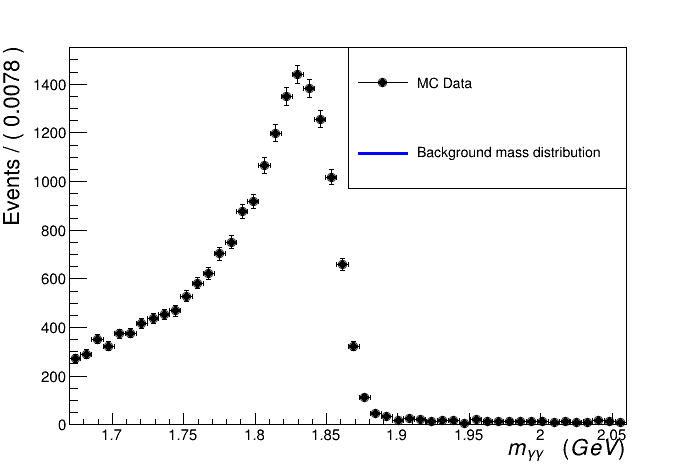

In [142]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Background Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleOffset(.6)
plot.SetXTitle(r"$m_{\gamma\gamma}$ (GeV)")
bkghist.plotOn(plot,ROOT.RooFit.Name("data"))
nonhiggs.plotOn(plot,ROOT.RooFit.Name("QCD"))

l = ROOT.TLegend( 0.5, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
bobj = plot.findObject("QCD")

l.AddEntry( dataobj , "MC Data", "pl" )
l.AddEntry( bobj , "Background mass distribution", "l"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()


In [143]:
fsig = ROOT.RooRealVar("fsig","signal fraction",0.02,0.,1.)

model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(hgammagamma,nonhiggs),ROOT.RooArgList(fsig))

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (ztautau)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


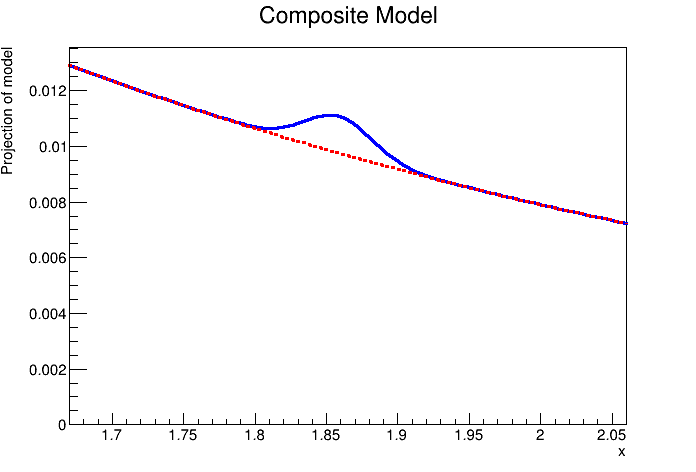

In [144]:
c1 = ROOT.TCanvas()
xframe = x.frame(ROOT.RooFit.Title("Composite Model"))
model.plotOn(xframe)
bkg_component = ROOT.RooArgSet(nonhiggs)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2),ROOT.RooFit.LineColor(2))
xframe.Draw()
c1.Draw()

In [145]:
w = ROOT.RooWorkspace("w")
getattr(w,'import')(sigpdf)
getattr(w,'import')(bkgpdf)
getattr(w,'import')(model)

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset sighist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::sigpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::x
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset bkghist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::bkgpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddPdf::model
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooGaussian::Hgammagamma
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::sigma
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::fsig
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooExponential::ztautau
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::lambda


In [146]:
datamodel = ROOT.RooAddPdf("datamodel","datamodel",ROOT.RooArgList(sigpdf,bkgpdf),ROOT.RooArgList(fsig))
data = datamodel.generate(ROOT.RooArgSet(x),10000)

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (ztautau)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


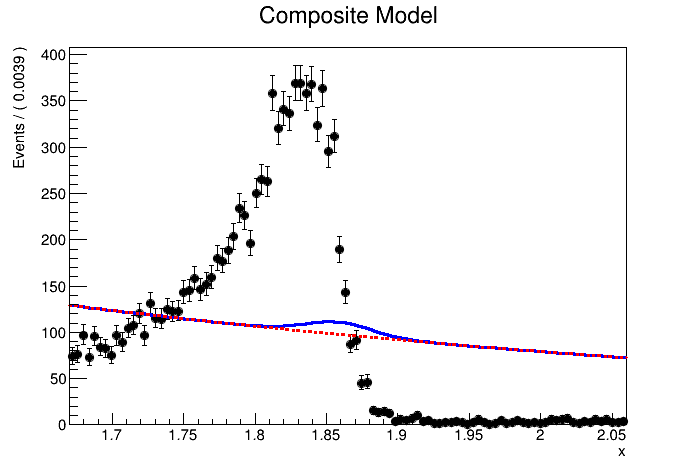

In [147]:
c1 = ROOT.TCanvas()
xframe = x.frame(ROOT.RooFit.Title("Composite Model"))
data.plotOn(xframe)
model.plotOn(xframe)
bkg_component = ROOT.RooArgSet(nonhiggs)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2),ROOT.RooFit.LineColor(2))
xframe.Draw()
c1.Draw()

In [148]:
getattr(w,'import')(data)


False

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset wu


In [149]:
mc = ROOT.RooStats.ModelConfig("ModelConfig",w)
mc.SetPdf(model)
mc.SetParametersOfInterest(ROOT.RooArgSet(w.var("fsig")))
mc.SetObservables(ROOT.RooArgSet(w.var("x")))
getattr(w,'import')(mc)

False

In [150]:
w.writeToFile("HgammagammaWS.root",True)


False